I decided to make a new notebook to continue week 4 as the last had become quite messy. Now I want to code what I will call "prediction lines" sitting vertically above the wavelengths of expected lines.   

To do this I need to:    
1. Take from the comparison papers what we are actually expecting to see.
2. Use a minimum strength filter on the NIST database.
3. Somehow take note of each of the lines and their corresponding ions.
4. Plot these above a normalised weighted average graph of the selected reigon.

From "Debris Disks: Structure, Composition, and Variability" (https://arxiv.org/pdf/1802.04313.pdf) I noted the following abundancies:  

    Found in beta pic:     
        Na      
        C     
        Lithophile materials (Mg, Al)   
        Siderophile materials (Fe, Ni)   
        O   
        Cu
        Cr(?)
        Also noted that there has never been a stable H detection.
            
    Found in other systems (49 Ceti, HD 32297, HD 172555):
        Mg
        Fe
        Mn
        C
        O
        Cl
        S
        Si
        Al
        Na


I conclude that we can expect to see most of if not all of the above elements in some amounts. One thing all the papers were very consistent about was the over-abundancies of C. This was interesting to me as I had found no traces in the small search that I did in week 3. 

In [30]:
# Now creating arrays of expected wavelengths
# To do this I applied a very restrictive minimum strength on NIST (1.2e+08), removed uneccessary columns copied into 
# Google Sheets so that I could quickly copy just the wavelength column

# Carbon (I and II)
Carbon = [1323.951 ,1329.0861 ,1329.5777 ,1334.532 ,1335.708 , 1431.597, 1432.1070, 1432.530]

#Sodium (III)
#Na = [1 325.700 ,1 336.760, 1 337.358 , 1 337.995, 1 340.674, 1 355.281 ,1 361.896 ,1 361.896 ,1 418.559 ,1 420.885]

#Iron
#Fe = [1 330.950,1 358.931,1 359.050,1 360.440,1 361.359,1 364.572,1 365.669,1 366.386,1 366.714,1 368.255,1 371.017,1 371.385,1 373.714,1 374.830,1 375.176,1 377.983,1 379.463,1 381.729,1 383.574,1 386.182,1 397.836,1 424.027,1 428.692,1 430.782,1 430.895]

#Aluminum
#Al = []

#Magnesium
#Mg = []

#Nickel
#Ni = []

#Oxygen (IV and V)
Oxygen = [1338.612, 1343.512, 1371.292]

## I am uncertain if I am doing this correctly, has setting such a high minimum strength made all of these 
## lines correspond to very large energy level differences and therefore quite unlikely?
## I will continue here to prove the method with only Carbon (as I have noted already the double, which is visable here)


In [31]:
import numpy as np
import json, sys, os

import matplotlib.pyplot as plt
from matplotlib import rc, cm

## Preparing astropy units and constants to be used later
from astropy import units as u
from astropy import constants as const

# Get the path of the current directory
path = os.getcwd()
home = os.path.dirname(path)

# Print the repository home directory
print("Repository home directory:",home)

# Add the src folder to the system path
sys.path.append(home+'/src')

# Import the python functions stored in the src folder
from calculations import Calc, Model, Stats

# We shorten the functions name to make it easier to call the required a functions
## 3 functions from P.Strom written code
c   = Calc()
m   = Model()
s   = Stats()

## My set_w function 

def set_w(lowerw,upperw):
    # Must make w, w_LHS and w_RHS global here so that they can be recalled later outside of the function
    #otherwise they stay as just local inside set_w
    global w
    global w_LHS
    global w_RHS
    
    #Finding the wavelength range to then find the number of data points per angstrom
    w = D[0][0][0][0:20248]
 
    # Wavelength range
    w_range = (w[20247]-w[0])

    # Data points per wavelength
    p_per_w = 20248/w_range
    
    LHS_gap_w = (lowerw-w[0]) #LHS difference in angstroms 
    LHS_gap_d = LHS_gap_w*p_per_w # LHS difference in points
    LHS_gap_d = round(LHS_gap_d)
    
    RHS_gap_w = (w[20247]-upperw) #RHS difference in angstroms 
    RHS_gap_d = RHS_gap_w*p_per_w # RHS difference in points
    RHS_gap_d = round(RHS_gap_d)
    
    w_LHS = 0 + LHS_gap_d
    w_RHS = 20248 - RHS_gap_d

    w = D[0][0][0][w_LHS:w_RHS] #Redefining w with its new boundaries

    return(w)



# Importing parameters from a json file.
# You can use this file to edit parameters later.

## Editing the paramenters in a file proves easier than writing it into the code 
with open(home+'/params.json') as param_file:    
   param = json.load(param_file)

# We read in the data directories we are using. To see what directories this is open params.json.
datadirs = param["datadirs"]

# Choose what part of the spectrum you wan to look at
# B is the blue end, whilst A is the red end)
part     = param["BetaPictoris"]["part"]


## Just added this into the first cell as there wasnt any reason to have them split every other week
# Load the data into the multidimentional array D
if param["filenames"]["split_files"] == "yes":
    D = c.LoadData(home+'/data/D_'+part+'_split.npz')
else:
    D = c.LoadData(home+'/data/D_'+part+'.npz')

Repository home directory: C:\Users\Oliver\Documents\urss


In [32]:
# Setting wavelength region 
set_w(1320,1440)

array([1319.69879417, 1319.70876084, 1319.71872751, ..., 1438.79052125,
       1438.80048792, 1438.81045459])

In [33]:
# Applying Doppler shift 
beta_pic_speed = 20.5*(u.km/u.s)
w_shifted = w-(beta_pic_speed / const.c)*w

print(w)
print(w_shifted)

[1319.69879417 1319.70876084 1319.71872751 ... 1438.79052125 1438.80048792
 1438.81045459]
[1319.60855233 1319.61851831 1319.6284843  ... 1438.69213583 1438.70210182
 1438.71206781]


In [34]:
## From Week 2 and 3
## Code for Normalising the Points in new reigon

# Creating empty lists for our Flux, Error in Flux, corrected flux values 
d0 = [] # Flux
e0 = [] # Error
d0_n = [] # Corrected flux values (Normalised)

# Extracting the Flux and Flux Error data for each observation and putting them into d0 and e0
for i in range(len(D)): # For each visit (repeat for all 13 data collections)
    for j in range(len(D[i])): # Within each visit (cycle over number of orbits)
        if j == 0: # If orbit == 0 (for the first orbit only - as we are interested in unshifted data)
            d0.append(D[i][j][1][w_LHS:w_RHS]) # Add to d0 the y values (Flux)
            e0.append(D[i][j][2][w_LHS:w_RHS]) # Add to e0 the y error values (Error in Flux)
                ## This is why I had to make w_LHS and w_RHS global earlier as well as w
            
# Converting lists into numpy arrays (allowing for easier manipulation later on with averaging functions)
d0 = np.array(d0)
e0 = np.array(e0)


# Normalisation - correcting for different exposure times (exposure time effects Flux, we move all into same frame)

for i in range(len(d0)): # For loop - repeating for each data set 
    factor = np.median(d0[i])/np.median(d0[0]) # Calculating the normalisation factor (how much each spectrum is off from 1st)
    d0_n.append(d0[i]/factor) # (Spectrum flux values/spectrum normalisation factor), making d0_n corrected flux values 


# Converting list into array - only after using .append 
d0_n = np.array(d0_n)

## Simple average
#d0_ave = np.average(d0,axis=0)

## Weighted average
#d0_w_ave = np.average(d0 , axis = 0 , weights = 1/e0**2)

## Normalised weighted average 
d0_n_w_ave = np.average(d0_n , axis = 0 , weights = 1/e0**2)

print(d0_n_w_ave)

[1.66102031e-13 1.62472248e-13 1.64828637e-13 ... 3.93663267e-13
 3.96460244e-13 3.94187867e-13]


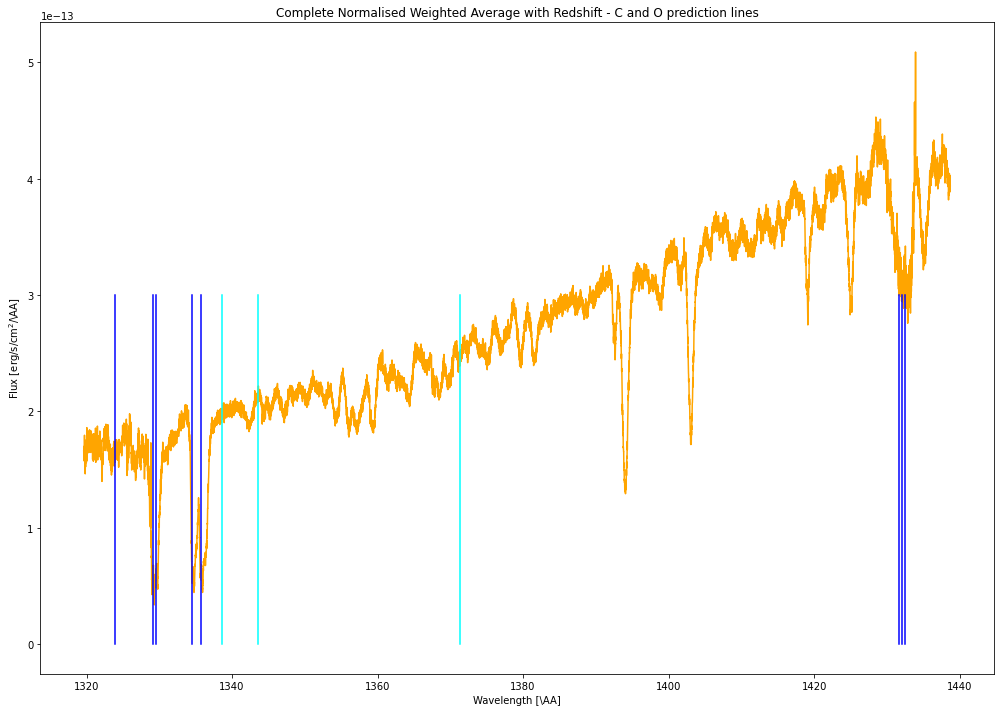

In [43]:
# Plotting the spectrum with the 

fig = plt.figure(figsize=(14.0,10.0))

# Normalised weighted average by shifted wavelengths
plt.plot(w_shifted, d0_n_w_ave , color = "orange")
plt.title("Complete Normalised Weighted Average with Redshift - C and O prediction lines")
plt.xlabel(r'Wavelength [\AA]')
plt.ylabel(r'Flux [erg/s/cm$^2$/\AA]')
fig.tight_layout()

#Creating a for loop to go through each expected wavelength and plot vertical lines 
for i in Carbon:
    plt.plot([i,i],[0e-13,3e-13],color="blue")
    
for i in Oxygen:
    plt.plot([i,i],[0e-13,3e-13],color="cyan")
    

This shows perfectly how that the code/method works perfectly for the carbon lines but not really for the oxygen lines. It is great to see a proof of concept that it works great for the carbon lines. However I think that the reason why is because the oxygen data that I got from NIST must be from too high oxidisation levels.    
Can we talk about this as I am not sure how to get around this - getting the right expected wavelengths but also not having hundruds on there (as we only want large ones). One possible solution I have is searching manually and finding a couple lines then specifying better in NIST which lines I want to see eg just O III. (To test this idea I now add Manganese  - Mn II lines as I detected a couple in week 3 and might be able to predict more)

In [42]:
MnII = [1409.51,1415.15,1415.75,1418.13,1425.544,1432.78]

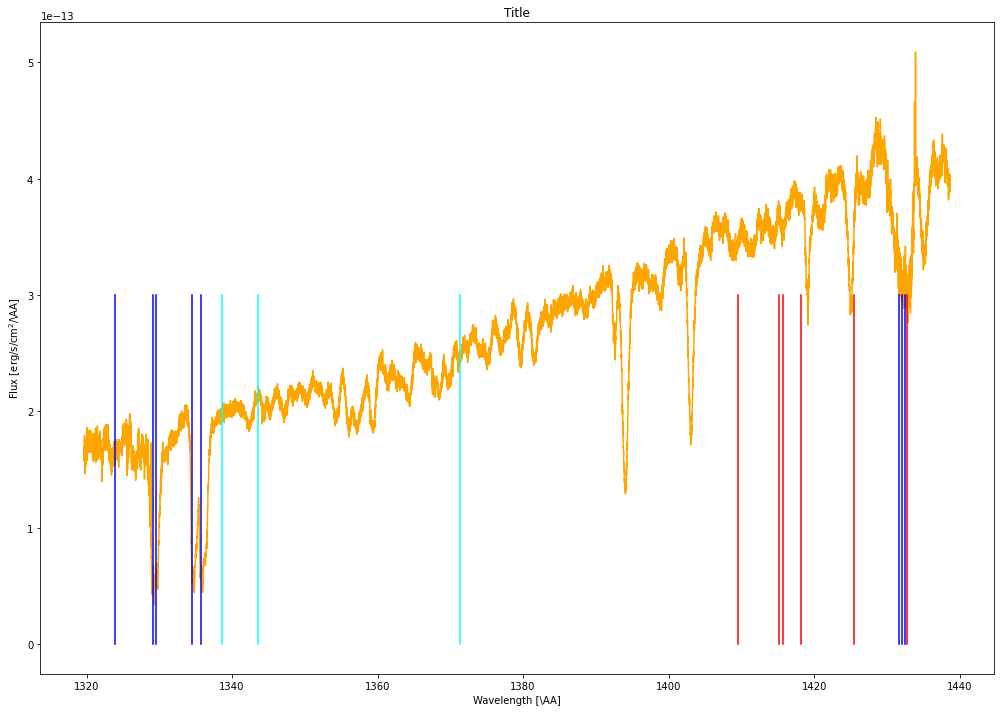

In [44]:


fig = plt.figure(figsize=(14.0,10.0))

# Normalised weighted average by shifted wavelengths
plt.plot(w_shifted, d0_n_w_ave , color = "orange")
plt.title("Title")
plt.xlabel(r'Wavelength [\AA]')
plt.ylabel(r'Flux [erg/s/cm$^2$/\AA]')
fig.tight_layout()

#Creating a for loop to go through each expected wavelength and plot vertical lines 
for i in Carbon:
    plt.plot([i,i],[0e-13,3e-13],color="blue")
    
for i in Oxygen:
    plt.plot([i,i],[0e-13,3e-13],color="cyan")
    
for i in MnII:
    plt.plot([i,i],[0e-13,3e-13],color="red")

This gives me mixed messages, I think that it is certainly a decent couple of predictions, especially the highest wavelength 2. However with the minimum absorption so high I am sure it has missed many out (eg the ones I identified in week 3).

For now this is as far as I will go with the prediction lines - I hope that we can talk about this. (End of objective 2)

Moving onto objective 1, rechecking the lines I found in week 3 with better understanding from reading the literature. I analysed all of the papers to deal with objective 3 so with the my new understanding I have reconsidered the findings from week 3. 

    Possible matches using from NIST:
    ( ___ = no match , XX XX = close match , XX XX (?) = weaker match)
    1342.3410 = 
    1344.1449 = Mn II 
    1344.3547 = Mn II 
    1344.4040 = W III (?)
    1345.1417 = W III(?)
    1345.2714 = Ir IV (?)
    1347.1451 = 
    1347.1846 = 
    1348.4101 = W III
    1350.2838 = Re III (?)
    1352.6260 = Si II (?) 
    1352.8251 = Mn II (?) / AU I (?)
    *1354.1809 = Sr IV (Wasnt this one of the ones that had been noted before? -  Highly reactive so interesting)
    *1356.0641 = Fe III
    *1357.1804 = Co II 
    1359.3223 = Fe II 
    *1359.3820 = Y V (?)
    1361.2967 = S I (?)
    1361.5158 = Y V (?)
    1362.6314 = W III
    1362.6819 = PT II (?)
    1362.7017 = Bi III (?)
    *1364.3964 = W III (?)
    

From here we can safely assume (perhaps open to revisiting exotic lines with particularly strong cases later), that Sr IV, Y V, Ir IV and Re III are almost certainly not there.    

I would also say there are some with much higher chances of actually being there: Si II, Fe III, Mn III      

The most curious for me are the transition metals higher than Fe - mainly the Tungsten W III. They have no reason to not be there in terms of radioactivity or high reactiveness with other elements present but they are very rare in comparison to what should have been found (from abundance of chemical elements etc). I am presuming that what has been detected is just coincidence or in such low abundance it was just luck it was detected and there isnt actually enough there for any significance. 